# Retention Scoring
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [18]:
import boto3
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *
from data_sci_toolkit.aws_tools import permission_tools

In [46]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile US-StellarSupport
    session = boto3.setup_default_session(profile_name='US-StellarSupport')

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6942, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6942 entries, 0 to 6941
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6942 non-null   int64  
 1   year                 6942 non-null   int64  
 2   productGrouping      6942 non-null   object 
 3   email                6925 non-null   object 
 4   ticketingid          6942 non-null   object 
 5   totalSpent           6942 non-null   float64
 6   recentDate           6942 non-null   object 
 7   attendancePercent    6942 non-null   float64
 8   renewedBeforeDays    6942 non-null   int64  
 9   source_tenure        6942 non-null   int64  
 10  tenure               6942 non-null   int64  
 11  distToVenue          6768 non-null   float64
 12  recency              6942 non-null   int64  
 13  missed_games_1       6942 non-null   int64  
 14  missed_games_2       6942 non-null   int64  
 15  missed_games_over_2  6942 non-null   i

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "email",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","email","productGrouping","ticketingid","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7290,0.8167,0.6752,0.7553,0.7122,0.4576,0.4610,0.9530


In [8]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7320,0.8245,0.6954,0.7447,0.7192,0.4635,0.4645
1,0.7484,0.8291,0.6447,0.8099,0.7179,0.4960,0.5066
2,0.7353,0.8325,0.6645,0.7710,0.7138,0.4701,0.4746
3,0.7516,0.8470,0.7303,0.7603,0.7450,0.5031,0.5035
4,0.6765,0.7896,0.6645,0.6779,0.6711,0.3528,0.3529
5,0.7059,0.7865,0.6579,0.7246,0.6897,0.4114,0.4131
6,0.7353,0.8163,0.7105,0.7448,0.7273,0.4704,0.4709
7,0.6830,0.7758,0.6250,0.7037,0.6620,0.3655,0.3678
8,0.7647,0.8389,0.6974,0.8030,0.7465,0.5290,0.5336


### Let's load in our 2021 season data and get retention scores using the model:

In [21]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2708, 17)

In [22]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6750,0,0.0000,0.0000,0.0000,0.0000,0.0000


In [23]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    1828
1     880
Name: Label, dtype: int64


In [24]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (0.25, 0.5]       1040
(-0.001, 0.25]     788
(0.5, 0.75]        623
(0.75, 1.0]        257
Name: Score_1, dtype: int64


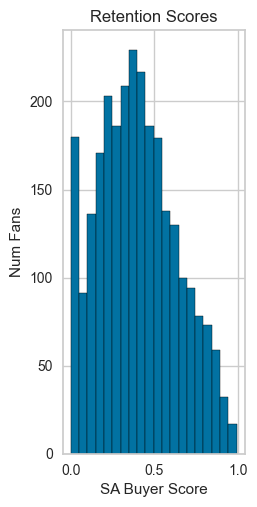

In [25]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

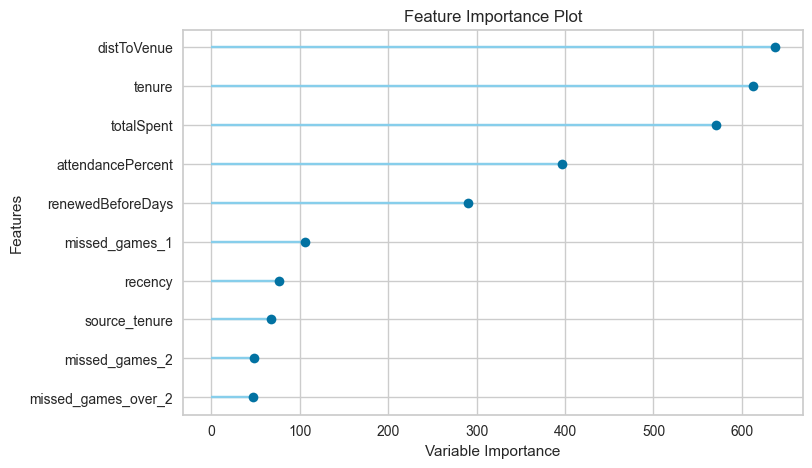

In [26]:
plot_model(lightgbm_model, plot='feature')

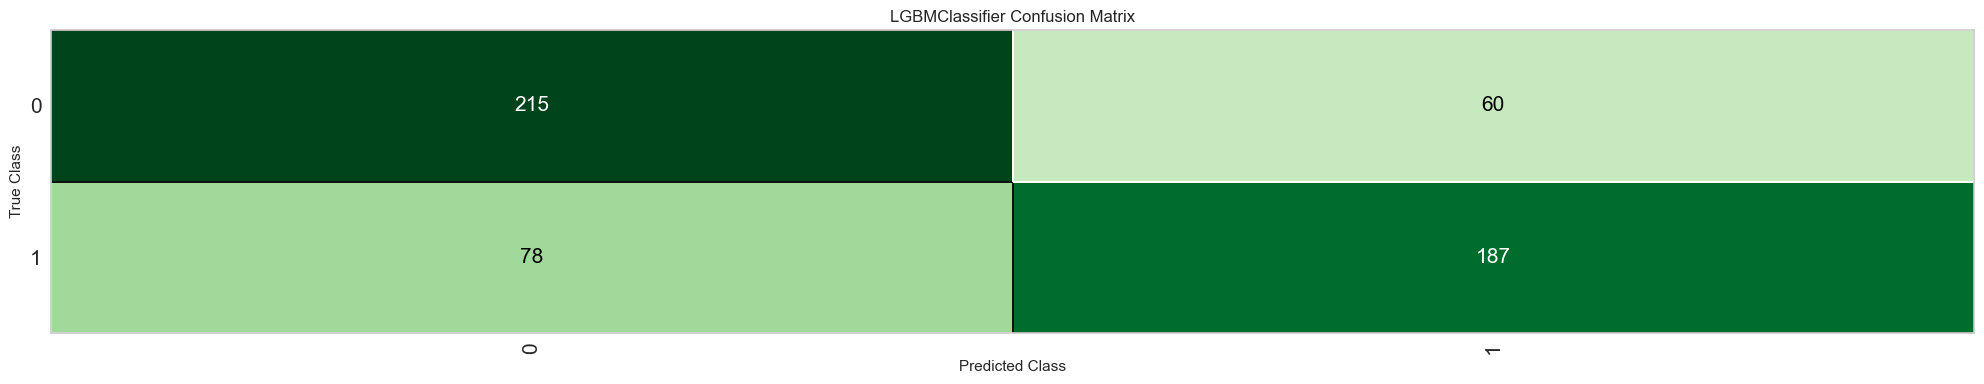

In [27]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [28]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
2,52,2022,Full Season,06guer1103@gmail.com,253859,1926.10,2022-10-09,1.00,96,730,746,17.84,0,0,0,0,0,0,0.5132,0.4868
5,179,2022,Flex Plan,195cleanup@gmail.com,270764,312.00,2022-07-13,0.88,9,730,150,38.20,0,0,0,0,0,0,0.9882,0.0118
9,466,2022,Full Season,4jcmas@gmail.com,232105,12257.00,2022-10-05,0.56,162,730,949,48.37,0,2,1,0,0,1,0.2953,0.7047
12,530,2022,Full Season,6xiirt@gmail.com,277117,875.50,2022-10-05,0.63,159,730,758,57.52,0,3,1,0,0,0,0.6227,0.3773
15,632,2022,Full Season,9espi9@gmail.com,295807,439.84,1970-01-01,0.00,162,730,752,47.79,0,0,0,1,0,0,0.8176,0.1824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,990211,2022,Flex Plan,zegman.88@gmail.com,259397,438.00,2022-07-13,1.00,9,730,27,50.84,0,0,0,0,0,0,0.9989,0.0011
6935,11686478,2022,Full Season,xmikerurx@gmail.com,150931,4815.25,2022-10-09,0.72,162,1095,1054,59.73,0,1,0,0,0,1,0.3050,0.6950
6936,11919301,2022,Flex Plan,bocelli71@aol.com,1559117,146.00,2022-10-05,1.00,36,0,36,22.40,0,0,0,0,0,0,0.9724,0.0276
6938,11999374,2022,Full Season,mattmueller2030@gmail.com,300749,1575.90,2022-10-09,0.63,80,730,913,30.30,0,5,0,0,0,1,0.3803,0.6197


In [29]:
current_date = datetime.today().strftime('%Y-%m-%d')

In [30]:
df_output = pd.DataFrame()
df_output["attendancepercentage"] = lightgbm_predictions["attendancePercent"]
df_output["clientcode"] = "mlsintermiami"
df_output["dimcustomermasterid"] = lightgbm_predictions["dimCustomerMasterId"]
df_output["email"]= lightgbm_predictions["email"]
df_output["lkupclientid"] = 113
df_output["mostrecentattendance"] = lightgbm_predictions["recentDate"]
df_output["product"] = lightgbm_predictions["productGrouping"]
df_output["sascore"] = lightgbm_predictions["Score_1"]
df_output["scoredate"] = current_date
df_output["seasonyear"] = lightgbm_predictions["year"]
df_output["tenuredays"] = lightgbm_predictions["tenure"]
df_output["ticketingid"] = lightgbm_predictions["ticketingid"]

In [58]:
s3 = boto3.resource('s3')

bucket = "us-curated-data-sci-retention-us-east-1-5h6cml"
current_date = datetime.today().strftime('%Y-%m-%d')
path = "./data/retention-scores.csv"

df_output.to_csv(path)
s3.Bucket(bucket).upload_file(path, f'date={current_date}/mlsintermiami/scores.csv')

### Done